# Analyze Dataset Meta Data SIze Distribution



In [110]:
from __future__ import print_function
import requests
import json
import collections
from pandas.io.json import json_normalize
import time
import os
import socket
import pandas as pd

In [111]:
# api-endpoints
apiserver="dacat.psi.ch"
API = "https://"+apiserver+"/api/v3"
MSAD= "https://"+apiserver+"/auth/msad"
    
def login(user,pw):
    access_token=''
    data = {'username':user,'password':pw} 
    r = requests.post(url = API +'/Users/login', data = data)
    if (r.status_code == 200):
        access_token = r.json()['id']
    else:
        r = requests.post(url = MSAD, data = data)
        if (r.status_code == 200):
            access_token = r.json()['access_token']
        else:
            print("Could not login, access_token undefined")
    token=access_token  
    return token 
    
def flatten(d, parent_key='', sep='.'):
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, collections.MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

def getKeys():
    # read first dataset to extract keys
    # where = {"datasetName":"disk1/VB1721Glob_/tif"}
    where = {}
    params = {"where":where, "limit":1}
    # defining a params dict for the parameters to be sent to the API 
    PARAMS = {'filter':json.dumps(params), 'access_token':token} 
    r = requests.get(url = API+"/Datasets", params = PARAMS) 
    # extracting data in json format 
    data = r.json()
    # extract keys
    flattened_dataset=flatten(data[0])
    # TODO create shortend names and example values
    return flattened_dataset.keys()
        
def get_datasets(token):
    # where = {"creationLocation":"/PSI/SLS/TOMCAT"}
    # where = { 'ownerGroup': 'p17880'}
    # where={"creationLocation":"/PSI/SLS/PHOENIX"}
    where = {}
    # get count first and then read in batches
    PARAMS = {'where':json.dumps(where),'access_token':token} 
    # sending get request and saving the response as response object 
    r = requests.get(url = API+"/Datasets/count", params = PARAMS)  
    data = r.json() 
    print("Number of datasets:",data)
    # predefine key list 
    selected_options=['size', 'ownerGroup', 'datasetlifecycle.retrievable']
    fields = { key:1 for key in selected_options }
    print("Waiting for results:")
    par = {"fields":fields,"where":where}
    # defining a params dict for the parameters to be sent to the API 
    PARAMS = {'filter':json.dumps(par), 'access_token':token} 
    # sending get request and saving the response as response object 
    r = requests.get(url = API+"/Datasets", params = PARAMS) 
    # extracting data in json format and flatten tree
    data = r.json() 
    df = json_normalize(data) 
    result=df
    return result


In [115]:
import getpass
password = getpass.getpass()

········


In [116]:
token=login("ingestor",password)
data=get_datasets(token)
import numpy as np
data['logsize']=np.log10(data['size']+1)


Number of datasets: {'count': 310942}
Waiting for results:


In [117]:
data.head()

,datasetlifecycle.retrievable,ownerGroup,size,logsize
0,True,p18243,5.940065e+07,7.773791
1,True,p17621,1.449889e+10,10.161335
2,False,p13388,0.000000e+00,0.000000
3,False,p12370,0.000000e+00,0.000000
4,True,p17962,1.247562e+08,8.096062


In [118]:
filter=data['datasetlifecycle.retrievable']

In [119]:
archivedData=data[filter]

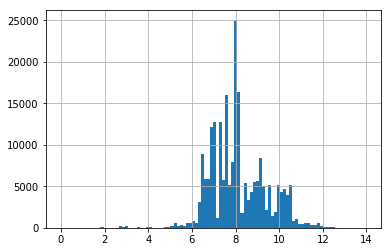

In [120]:
hist2=archivedData.logsize.hist(bins=100)

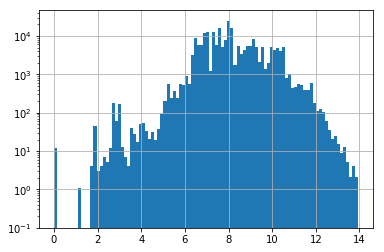

In [121]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
archivedData.logsize.hist(ax=ax, bins=100, bottom=0.1)
ax.set_yscale('log')


In [122]:
mn=archivedData['size'].mean()
print(mn,np.log10(mn))
std=archivedData['size'].std()
print(std,np.log10(std))

18578978820.363407 10.26902183964314
460883453818.0482 11.663591116793413


## To summarize
The two plots show log(size) on the x -axis on a linear(upper plot) and log10 (lower plot) y axis
The distribution of the dataset sizes is very broad with a mean of 18.6 GBi and a standard deviation of 460 GB